In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [2]:
# LOAD ROBOT
robot = loadKinton()
robot.initDisplay(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

In [3]:
# DEFINE TARGET POSITION
target_pos  = np.array([0,0,1])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

# Plot goal frame
robot.viewer.gui.addXYZaxis('world/framegoal', [1., 0., 0., 1.], .015, 4)
robot.viewer.gui.applyConfiguration('world/framegoal', target_pos.tolist() + [target_quat[0], target_quat[1], target_quat[2], target_quat[3]])
robot.viewer.gui.refresh()

In [171]:
# ACTUATION MODEL
actModel = ActuationModelUAM(robot.model)

# COST MODEL
# Create a cost model per the running and terminal action model.
runningCostModel = CostModelSum(robot.model, actModel.nu)
terminalCostModel = CostModelSum(robot.model, actModel.nu)

frameName = 'base_link'
state = StatePinocchio(robot.model)
SE3ref = pin.SE3()
SE3ref.translation = target_pos.reshape(3,1)
SE3ref.rotation = target_quat.matrix()


stateWeights   = np.array([1] * 3 + [500.] * 3 + [1] * (robot.model.nv - 6) + [10] * robot.model.nv)
controlWeights = np.array([10] + [0]*3 + [0]*6)

goalTrackingCost = CostModelFramePlacement(robot.model,
                                           frame=robot.model.getFrameId(frameName),
                                           ref=SE3ref,
                                           nu =actModel.nu)
xRegCost = CostModelState(robot.model, 
                          state, 
                          ref=state.zero(), 
                          nu=actModel.nu,
                          activation=ActivationModelWeightedQuad(stateWeights))
uRegCost = CostModelControl(robot.model, 
                            nu=robot.model.nv-2,
                            activation = ActivationModelWeightedQuad(controlWeights))

# Then let's add the running and terminal cost functions
runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
runningCostModel.addCost(name="regx", weight=1e-4, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
terminalCostModel.addCost(name="pos", weight=50, cost=goalTrackingCost)

# DIFFERENTIAL ACTION MODEL
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [166]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 1e-3
runningModel.timeStep = dt

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1000
q0 = robot.model.referenceConfigurations["initial_pose"]

x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverDDP(problem)
# ddp.callback = [CallbackDDPVerbose()]
# ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([-6.88573659e-11,  1.89394694e-21,  6.58163248e-05,  6.03265314e-19,
          3.62430595e-08, -1.24010256e-21,  1.00000000e+00,  3.06519240e-19,
          7.19909796e-18,  1.47554745e-06,  8.16321529e-07,  3.21751347e-07,
          6.40084325e-21, -7.12427509e-08,  1.93365165e-18,  6.58163248e-02,
          1.20653063e-15,  7.24861190e-05, -2.48020511e-18,  3.06519240e-16,
          7.19909796e-15,  1.47554745e-03,  8.16321529e-04,  3.21751347e-04,
          6.40084325e-18]),
  array([-1.27472383e-10,  3.61259026e-21,  1.96575784e-04,  1.18608153e-18,
          7.11739928e-08,  4.64825655e-22,  1.00000000e+00,  6.06278452e-19,
          1.43156088e-17,  2.93738078e-06,  1.62471653e-06,  6.40041695e-07,
          7.35325679e-21, -7.26608126e-08,  1.95261735e-18,  1.30759459e-01,
          1.16563243e-15,  6.98618665e-05,  3.40985652e-18,  2.99759212e-16,
     

In [175]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

In [173]:
# Control trajectory
thrust = []
Mr = [];
Mp = [];
My = [];

for u in ddp.us:
    thrust.append(u[0])
    Mr.append(u[1])
    Mp.append(u[2])
    My.append(u[3])

# State trajectory
Xx = [];
Xy = [];
Xz = [];

for x in ddp.xs:
    Xx.append(x[0])
    Xy.append(x[1])
    Xz.append(x[2])

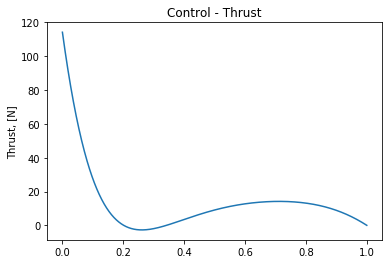

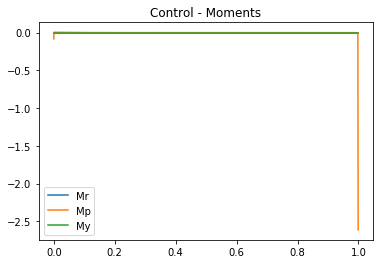

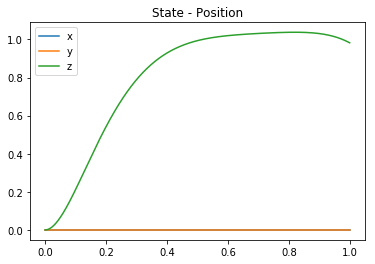

In [174]:
import matplotlib.pyplot as plt
t = np.arange(0., T*dt, dt)

plt.figure()
plt.plot(t, thrust)
plt.ylabel('Thrust, [N]')
plt.title('Control - Thrust')

plt.figure()
plt.plot(t,Mr, t,Mp, t,My)
plt.legend(['Mr','Mp','My'])
plt.title('Control - Moments')

plt.figure()
t = np.append(t, 1)
plt.plot(t,Xx,t,Xy,t,Xz)
plt.legend(['x','y','z'])
plt.title('State - Position')

In [133]:
t = np.append(t, 1)
t

array([0.   , 0.001, 0.002, ..., 0.998, 1.   , 1.   ])

In [29]:
state

<crocoddyl.state.StatePinocchio instance at 0x7f85d168fa28>

In [15]:
7+6+12

25